# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


In [17]:
# Various imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

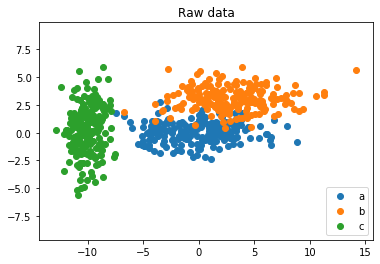

In [4]:
# View data

plt.scatter(a[:,0], a[:,1])
plt.scatter(b[:,0], b[:,1])
plt.scatter(c[:,0], c[:,1])
plt.axis('equal')
plt.legend(("a","b","c"))
plt.title("Raw data")
plt.show()

### 1.0 Implementation

The implementation is composed of three main functions.
- plotResults() which displays results formated properly, it uses the contour function to find the 0 level of the difference between each class' discrimination function, corresponding to the class' interfaces.
- getSIGs() which computes the covariance matrix to be used for the Bayesian classification depending on the desired method (Full, Mahalanobis, Euclidean).
- computeSepFunc() which computes the values of the discrimination functions for all points of the feature space.

The implementation is not very efficient due to the huge loop in the computeSepFunc() function, but optimization was not considred inside of the scope of this lab.

In [42]:
def plotResults(X,Y,Z1,Z2,Z3,method) :
    plt.contour(X,Y,Z1,[0], colors='y')
    plt.contour(X,Y,Z2,[0], colors='pink')
    plt.contour(X,Y,Z3,[0], colors='cyan')
    plt.scatter(a[:,0], a[:,1], color='r')
    plt.scatter(b[:,0], b[:,1], color='g')
    plt.scatter(c[:,0], c[:,1], color='b')

    AB_patch = mlines.Line2D([], [], color='y',label="Sep. A and B")
    AC_patch = mlines.Line2D([], [], color='pink',label="Sep. A and C")
    CB_patch = mlines.Line2D([], [], color='cyan',label="Sep. C and B")
    A_patch = mlines.Line2D([], [], color='r',label="A", linewidth=0, marker='o')
    B_patch = mlines.Line2D([], [], color='g',label="B", linewidth=0, marker='o')
    C_patch = mlines.Line2D([], [], color='b',label="C", linewidth=0, marker='o')
    
    plt.legend(handles=[AB_patch, AC_patch, CB_patch, A_patch, B_patch, C_patch])
    plt.title("Results using {} Bayesian classification".format(method))
    plt.axis('equal')
    plt.show()

In [13]:
def getSIGs(a,b,c,method) :
    if method == "Full" :
        a_SIG = np.cov(a.T)
        b_SIG = np.cov(b.T)
        c_SIG = np.cov(c.T)
    elif method == "Mahalobis" :
        a_SIG = np.cov(a.T)
        b_SIG = np.cov(b.T)
        c_SIG = np.cov(c.T)
        a_SIG = b_SIG = c_SIG = (a_SIG + b_SIG + c_SIG)/3
    elif method == "Euclidean" :
        sig2_tot = np.mean([np.var(a[:,0]), np.var(a[:,1]), np.var(b[:,0]), np.var(b[:,1]), np.var(c[:,0]), np.var(c[:,1])])
        a_SIG = b_SIG = c_SIG = np.array([[sig2_tot, 0],[0, sig2_tot]])
    else :
        print("Unkown method")
        
    return a_SIG, b_SIG, c_SIG
        

In [40]:
def computeSepFunc(a,b,c,method="Full") :
    # Comptuing mean and probability to belong to a class
    nbrPtsTot = len(a[:,0]) + len(b[:,0]) + len(c[:,0])

    a_mean = np.mean(a, axis=0)
    a_p = np.log(len(a[:,0])/nbrPtsTot)

    b_mean = np.mean(b, axis=0)
    b_p = np.log(len(b[:,0])/nbrPtsTot)

    c_mean = np.mean(c, axis=0)
    c_p = np.log(len(c[:,0])/nbrPtsTot)
    
    # Computing SIG
    a_SIG, b_SIG, c_SIG = getSIGs(a,b,c,method)

    # Computing discriminant function limits
    delta = .1
    xrange = np.arange(-15, 15, delta)
    yrange = np.arange(-8, 8, delta)
    X, Y = np.meshgrid(xrange,yrange)


    g_a = lambda x,y : -0.5*(np.array([x,y]) - a_mean).dot(np.linalg.inv(a_SIG)).dot(np.array([x,y]) - a_mean) + a_p + np.log(1/(2*np.pi*np.sqrt(np.abs(np.linalg.det(a_SIG)))))
    g_b = lambda x,y : -0.5*(np.array([x,y]) - b_mean).dot(np.linalg.inv(b_SIG)).dot(np.array([x,y]) - b_mean) + b_p + np.log(1/(2*np.pi*np.sqrt(np.abs(np.linalg.det(b_SIG)))))
    g_c = lambda x,y : -0.5*(np.array([x,y]) - c_mean).dot(np.linalg.inv(c_SIG)).dot(np.array([x,y]) - c_mean) + c_p + np.log(1/(2*np.pi*np.sqrt(np.abs(np.linalg.det(c_SIG)))))
    z1 = lambda x,y : g_a(x,y) - g_b(x,y)
    z2 = lambda x,y : g_a(x,y) - g_c(x,y)
    z3 = lambda x,y : g_c(x,y) - g_b(x,y)

    Z1 = np.zeros_like(X)
    Z2 = np.zeros_like(X)
    Z3 = np.zeros_like(X)
    for i in range(X.shape[0]) :
        for j in range(X.shape[1]) :
            Z1[i,j] = z1(X[i,j],Y[i,j])
            Z2[i,j] = z2(X[i,j],Y[i,j])
            Z3[i,j] = z3(X[i,j],Y[i,j])
            
    # Plotting results
    plotResults(X,Y,Z1,Z2,Z3,method)
    

$\left(\ln\Sigma_{i2}\right)$

### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

#### Analytical expression
$g_i(x,y) - g_j(x,y) = 0$

with

$g_i(x,y) = - \frac{1}{2} \left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right)^T \cdot \Sigma_{i,Full} \cdot \left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right) + \ln(P(\omega_i)) + \ln(c_i)$

where

$\Sigma_{i,Full} = [[\sigma_{x_ix_i}^2\ \sigma_{x_iy_i}^2],[\sigma_{x_iy_i}^2\ \sigma_{y_iy_i}^2]]$

#### Discussion
Using a full covariance matrix which is different for each class, this classification assumes that :
- each class follows a normal distribution
- each class has enough points to compute its covariance matrix meaningfully 
- each class has a different covariance matrix

Moreover, the probability to belong to a class $i$, $P(\omega_i)$ is given by the ratio between the number of points in class $i$ over the total number of points. 

As can be seen in the following figure, this method leads to good results, note the quadratic separations between the classes.

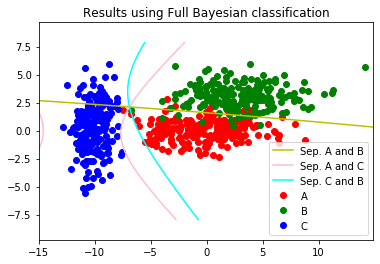

In [43]:
computeSepFunc(a,b,c,method="Full")

### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

#### Analytical expression
$g_i(x,y) - g_j(x,y) = 0$

with

$g_i(x,y) = - \frac{1}{2} \left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right)^T \cdot \Sigma_{Mahalanobis} \cdot \left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right)$

where

$\Sigma_{Mahalanobis} = [[\sigma_{xx}^2\ \sigma_{xy}^2],[\sigma_{xy}^2\ \sigma_{yy}^2]]$

The Mahalanobis distance hence can be written as:

$d_m(x,y,i) = \sqrt{\left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right)^T \cdot \Sigma_{Mahalanobis} \cdot \left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right)}$

#### Discussion
Using a full covariance matrix which is the same for each class, this classification assumes that :
- each class follows a normal distribution
- each class has a similar covariance matrix
- the overall covariance matrix can be computed as the mean covariance matrix of all classes
- each class has the same number of points and thus the likelyhood to belong to any class is equal.

As can be seen in the following figure, despite the additional and restrictive hypotheses, this method still leads to good results, note the linear separations between the classes.

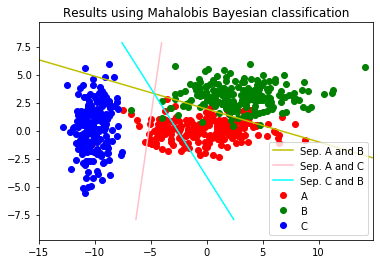

In [44]:
computeSepFunc(a,b,c,method="Mahalobis")

### 1.3 Euclidean distance

#### Analytical expression
$g_i(x,y) - g_j(x,y) = 0$

with

$g_i(x,y) = - \frac{1}{2} \left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right)^T \cdot \Sigma_{Euclidean} \cdot \left((x\ y) - (\mu_{i_x}\ \mu_{i_y})\right)$

where

$\Sigma_{Euclidean} = [[\sigma^2\ 0],[0\ \sigma^2]]$

#### Discussion
Using a $\sigma^2\cdot I$ (circular) covariance matrix which is the same for each class, this classification assumes that :
- each class follows a normal distribution
- each class has a similar and circular covariance matrix
- the overall $\sigma^2$ can be computed as the mean of the variances of all classes in both directions
- each class has the same number of points and thus the likelyhood to belong to any class is equal.

As can be seen in the following figure, due to the additional and even more restrictive hypotheses, this method still leads unsatisfying results (in par, note the linear separations between the classes.

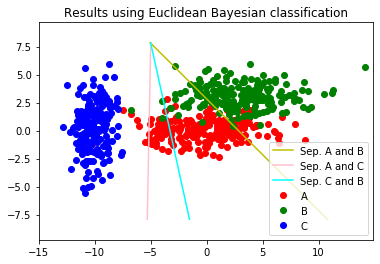

In [45]:
computeSepFunc(a,b,c,method="Euclidean")

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [14]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [15]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

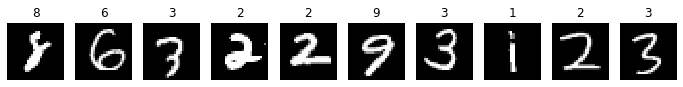

In [18]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP
*Add your implementation and discussion*

In [41]:
# Various imports

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [34]:
def vectImageArray(a) :
    """
    Transforms an array of images in a array of vectorised images
    """
    return np.reshape(a, (a.shape[0],a.shape[1]*a.shape[2]))

In [85]:
# Train
# hidden_layer_sizes=(50,50) => accuraxy = 0.9716
# hidden_layer_sizes=(33,33,33) => accuraxy = 0.9641

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(33, 33, 33), random_state=1, verbose=True)

scaler = StandardScaler()

setSize = 60000

scaler.fit(vectImageArray(train_images[:setSize,:]))
print("Done scaling")
X_train = scaler.transform(vectImageArray(train_images[:setSize,:]))

clf.fit(X_train, train_labels[:setSize])
print("Done training")

Done scaling
Done training


In [86]:
# Test
X_test = scaler.transform(vectImageArray(test_images[:setSize,:]))

s = clf.score(X_test,test_labels[:setSize])
print("Resulting accuracy is : {}".format(s))

Resulting accuracy is : 0.9641


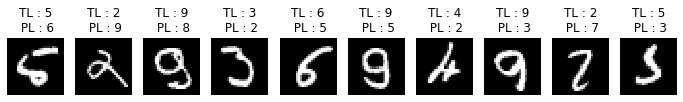

In [87]:
nbrFalse = 0
maxFalse = 10

listFalseId = []
listFalsePred = []
for i in np.arange(test_labels.shape[0]-1) :
    if nbrFalse >= maxFalse:
        break
    
    pred = clf.predict(X_test[i:i+1,:])[0]
    if test_labels[i] != pred :
        listFalseId.append(i)
        listFalsePred.append(pred)
        nbrFalse = nbrFalse + 1
        
fig, axes = plt.subplots(1, maxFalse, figsize=(12, 3))
for ax, i, pred in zip(axes, listFalseId, listFalsePred):
    ax.imshow(test_images[i,:,:], cmap='gray')
    ax.axis('off')
    ax.set_title("TL : {}\n PL : {}".format(test_labels[i],pred))
    

    